In [1]:
import os
import glob
import matplotlib.pyplot as plt
import random
from datasets import Dataset
from dotenv import load_dotenv
from huggingface_hub import login
import transformers
from transformers import AutoTokenizer

In [ ]:
from datasets import load_dataset, Dataset
load_dotenv()
hf_token = os.getenv('HF_TOKEN')
    

HuggingFace Token looks good so far


In [3]:
DATASET_NAME = "trade_code_data"
BASE_MODEL = "Qwen/CodeQwen1.5-7B"

In [4]:
def extract_method_bodies(text):
    chunks = text.split('def trade')[1:]
    results = []
    for chunk in chunks:
        lines = chunk.split('\n')[1:]
        body = '\n'.join(line for line in lines if line!='\n')
        results.append(body)
    return results 

In [5]:
bodies = []
for filename in glob.glob("*.py"):
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read()
        extracted = extract_method_bodies(content)
        bodies += extracted

print(f"Extracted {len(bodies)} trade method bodies")

Extracted 70 trade method bodies


In [6]:

print(random.choice(bodies))

    # Buy if the current price is higher than the average of the last 20 days
    trades = []
    for ticker in tickers:
        if prices[ticker][0] > np.mean(prices[ticker][1:21]):
            quantity = random.randrange(1, 100)
            trades.append(Trade(ticker, quantity))
    return trades




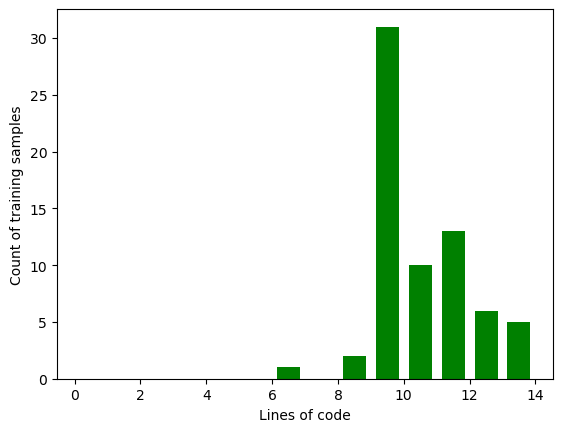

In [7]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
lengths = [len(body.split('\n')) for body in bodies]
ax.set_xlabel('Lines of code')
ax.set_ylabel('Count of training samples');
_ = ax.hist(lengths, rwidth=0.7, color="green", bins=range(0, max(lengths)))

In [8]:
prompt = """
# tickers is a list of stock tickers
import tickers

# prices is a dict; the key is a ticker and the value is a list of historic prices, today first
import prices

# Trade represents a decision to buy or sell a quantity of a ticker
import Trade

import random
import numpy as np

def trade():
"""

data = [prompt + body for body in bodies]
print(random.choice(data))


# tickers is a list of stock tickers
import tickers

# prices is a dict; the key is a ticker and the value is a list of historic prices, today first
import prices

# Trade represents a decision to buy or sell a quantity of a ticker
import Trade

import random
import numpy as np

def trade():
    # Sell if the current price is lower than the lower Keltner Channel
    trades = []
    for ticker in tickers:
        ema = prices[ticker][0]
        multiplier = 2 / (20 + 1)
        for i in range(1, 20):
            ema = (prices[ticker][i] - ema) * multiplier + ema
        atr = np.mean([np.max(prices[ticker][i:i+10]) - np.min(prices[ticker][i:i+10]) for i in range(10)])
        lower_channel = ema - 2 * atr
        if prices[ticker][0] < lower_channel:
            quantity = random.randrange(-100, -1)
            trades.append(Trade(ticker, quantity))
    return trades




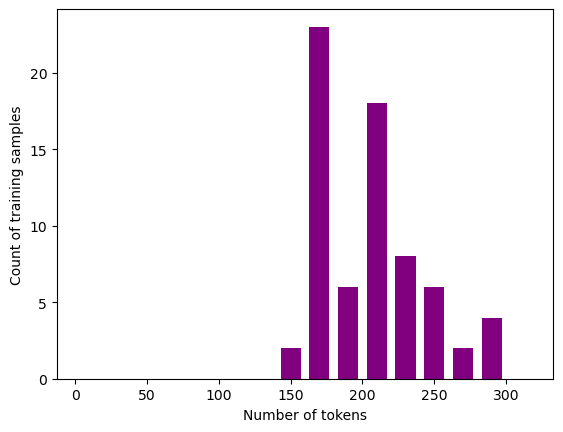

In [9]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenized_data = [tokenizer.encode(each) for each in data]
token_counts = [len(tokens) for tokens in tokenized_data]

%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of training samples');
_ = ax.hist(token_counts, rwidth=0.7, color="purple", bins=range(0, max(token_counts), 20))

In [10]:
CUTOFF = 320
truncated = len([tokens for tokens in tokenized_data if len(tokens) > CUTOFF])
percentage = truncated/len(tokenized_data)*100
print(f"With cutoff at {CUTOFF}, we truncate {truncated} datapoints which is {percentage:.1f}% of the dataset")

With cutoff at 320, we truncate 1 datapoints which is 1.4% of the dataset


In [11]:
filtered_data = [datapoint for datapoint in data if len(tokenizer.encode(datapoint))<=CUTOFF]
print(f"After now have {len(filtered_data)} datapoints")

After now have 69 datapoints


In [12]:
random.seed(42)
random.shuffle(filtered_data)

In [13]:
dataset = Dataset.from_dict({'text':filtered_data})

In [14]:
login(hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [15]:
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kesavk21/trade_code_data/commit/2ef0ec8797243f452e0b2ab495e8455be67bce32', commit_message='Upload dataset', commit_description='', oid='2ef0ec8797243f452e0b2ab495e8455be67bce32', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/kesavk21/trade_code_data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='kesavk21/trade_code_data'), pr_revision=None, pr_num=None)